In [1]:
import random
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import sys
import io
import copy
from tqdm.notebook import tqdm  # tqdm.notebookをインポート
from IPython.display import display, HTML
import cProfile


sys.path.append("../")
from models import Cars, ReservationTable, DFRSimulation, VFRSimulation, SuddenStopDFRSimulation, SuddenStopVFRSimulation
from utils import check_multiple_noise_effect, validate_with_ttc, generate_arrival_times_poisson, print_formatted_dict_list

# ↑↑↑↑↑↑↑↑↑この部分は別セルでも良い↑↑↑↑↑↑↑↑↑

def create_arrival_times_arithmetic_seq(step, n_max):
    return [i * step for i in range(n_max)]

def arithmetic_sequence(first_term, common_difference, num_terms):
    return [first_term + common_difference * n for n in range(num_terms)]

# 初期設定（独立変数群）
CAR_NUM = 300 #時間窓内の車の総数
START_TIME = 0
TOTAL_LENGTH = 3000 # 入り口から出口までの距離 [m]
NOISE_START_X = 2110
OBSERVATION_POINTS = [600, NOISE_START_X-1, 1950]

# 流量カウント用
flow_count_interval = 5
SEGMENT_LENGTH=100
flow_calc_start = 100 # 何秒後から流量の計測を始めるか


WAYPOINTS_NUM = 20 #constrained way pointの数
MEAN_SPEED = 20 # 秒速[m/s]として定義
MAX_SPEED = 25 # 秒速[m/s]として定義
MAX_ACC = 3 # m/s^sで定義, maxは0.3gにした
TIME_STEP = 0.1
PLOT_CONDITION=["noise_continue", "noise_created"]
# TOTAL_TIME = 100 # シミュレーション時間

# 研究用のパラメータ
TTC = 1.6 #車間時間を暫定的に定義
COMMUNICATION_SPEED = 0
LAMBDA = 2 # 台数密度を車間時間として定義

# ノイズ関連のパラメ-タ
NOISE_FREQUENCY = 11

arrival_times = create_arrival_times_arithmetic_seq(LAMBDA, CAR_NUM)
# arrival_times = [2.805611314755843, 4.8056113147558435, 12.45418334124825, 17.61211498044407, 21.674961724245826, 23.674961724245826, 25.674961724245826, 31.01738642384915, 33.0355321495912, 35.0355321495912, 37.0355321495912, 50.72232545890806, 53.28195113722663, 58.643046837549164, 60.643046837549164, 62.643046837549164, 66.3180561603613, 69.90570543546659, 71.90570543546659, 75.80826562583078, 83.18906347590797, 85.85451992305059, 87.85451992305059, 92.5756159681414, 94.5756159681414, 96.5756159681414, 98.5756159681414, 101.6651765089501, 103.6651765089501, 110.05413309381916, 113.78187314652725, 120.70411201001693, 124.5444753695085, 128.69066124619636, 130.69066124619636, 132.9643533178792, 136.10646274385812, 138.10646274385812, 140.10646274385812, 142.10646274385812, 144.21750870897847, 146.21750870897847, 149.8726371315692, 154.36629397943378, 157.73429300337168, 159.73429300337168, 166.10515448927555, 170.76587981468654, 177.6172249091577, 181.20674538328223, 183.20674538328223, 191.0856979310541, 195.7951292631883, 197.7951292631883, 199.7951292631883, 201.7951292631883, 203.7951292631883, 205.7951292631883, 210.84675914652456, 213.02016499169758, 216.13196411790912, 221.7631507383874, 223.7631507383874, 229.86053417345707, 231.86053417345707, 234.6564081083129, 240.25195126297137, 242.25195126297137, 244.7410730950167, 246.7410730950167, 250.32172232537462, 252.32172232537462, 254.79385093464091, 259.7887572694224, 261.7887572694224, 263.7887572694224, 265.7887572694224, 267.7887572694224, 269.7887572694224, 271.7887572694224, 277.411112520444, 281.9025054780484, 285.3708119307591, 288.9544430319777, 291.3127945778801, 293.3127945778801, 295.7890822041264, 299.79472825514387, 301.79472825514387, 303.79472825514387, 305.79472825514387, 307.8751945681391, 319.9547903024209, 322.1483555447243, 331.8288493420763, 348.5939101025975, 350.5939101025975, 352.5939101025975, 358.8615012107836, 360.8615012107836, 362.8615012107836, 365.69176010087796, 367.69176010087796, 380.8372263074677, 382.8372263074677, 385.691319886154, 394.9881156170315, 396.9881156170315, 400.68180490817275, 405.72720568461085, 409.7007037873151, 411.7007037873151, 415.1521106057683, 423.02322621117526, 428.3079852334132, 430.3079852334132, 434.31030792257644, 439.17473045212006, 441.30347417169185, 451.2960346943851, 459.8101482411158, 462.81830365416147, 464.81830365416147, 467.7967723288717, 469.7967723288717, 483.7104421950171, 485.7104421950171, 492.8950625540238, 494.8950625540238, 496.8950625540238, 498.92755939791897, 500.92755939791897, 508.5657624659219, 521.0310470290151, 523.1386398660222, 525.3410414471647, 554.3929044421307, 556.3929044421307, 558.3929044421307, 560.3929044421307, 562.3929044421307, 564.3929044421307, 567.9024564446015, 583.0467713239962, 585.0467713239962, 587.0467713239962, 592.27702203698, 596.8457966827882, 599.677970487058, 601.677970487058, 603.677970487058, 605.677970487058, 613.1543429045331, 619.879002414836, 624.5867848690966, 630.0694935928452, 632.0694935928452, 634.0694935928452, 639.7658686039352, 641.7658686039352, 666.6771781072678, 668.6771781072678, 670.6771781072678, 672.6771781072678, 682.2497900086923, 686.0672401944468, 692.6521960547575, 702.7151508374712, 705.7258074984599, 709.6871632249706, 713.2132603948002, 715.2132603948002, 720.1206752688595, 722.1206752688595, 729.8852133346647, 732.0306195109456, 734.0306195109456, 737.7301500421327, 739.7301500421327, 747.1990405287322, 749.8085855513195, 752.5008968312366, 756.9351794690243, 759.5399850821067, 762.8033006845096, 764.8033006845096, 770.182583910496, 772.182583910496, 774.3256284907151, 788.7507398509098, 790.7507398509098, 792.7507398509098, 795.4177302451491, 797.4177302451491, 800.3675501176599, 802.3675501176599, 804.3675501176599, 811.2721607726187, 813.2721607726187, 815.3417210412985]

car_params = {"v_mean":MEAN_SPEED, "v_max": MAX_SPEED, "a_max":MAX_ACC, "a_min":MAX_ACC}

noise_params ={"NOISE_FREQUENCY":NOISE_FREQUENCY, "NOISE_START_X":NOISE_START_X}
brake_params={ "decel": -2, "acc":2, "coast_time":3, "period": 2}

def register_initial_eta(cars):
    for idx, car in enumerate(CARS):
        desired_eta_list = car.create_desired_eta(WAYPOINTS)
        is_valid = reservation_table.validate(desired_eta_list)
        if is_valid:
            reservation_table.register(desired_eta_list)
        else:
            calibration_info = {"desired_list": desired_eta_list}
            calibrated_list, _ = reservation_table.calibrate_list(**calibration_info)
            # print(calibrated_list)
            # print()
            reservation_table.register(calibrated_list)
            car.my_list = calibrated_list

print(arrival_times[-1]-1)
TOTAL_TIME = min(arrival_times[-1]-1, 600)

597


In [2]:
# ここからDFRのシミュレーション
# 従属的に決まるもの
WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
group_id = 0
CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
              for index, time in enumerate(arrival_times)]

reservation_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})

simulation = SuddenStopDFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, TTC=TTC, \
                          reservation_table = reservation_table, noise_params=noise_params, brake_params=brake_params, COMMUNICATION_SPEED=COMMUNICATION_SPEED, DENSITY=LAMBDA, \
                          observation_points = OBSERVATION_POINTS, segment_length=SEGMENT_LENGTH, flow_count_interval=flow_count_interval)

# simulation.conduct_simulation(should_plot=True, plot_start=100, plot_finish=200)


In [3]:
#simulation.conduct_simulation(should_plot=False, plot_start=560, plot_finish=580)
cProfile.run('simulation.conduct_simulation(should_plot=False, plot_start=120, plot_finish=135 )', 'profile_result.prof')
import pstats
stats = pstats.Stats('profile_result.prof')
stats.strip_dirs().sort_stats('cumulative').print_stats(20)  # 上位20件を表示

Simulation Progress DFR, density=2:   0%|          | 0/5970 [00:00<?, ?it/s]

===DEBUG===
{'t_start': 139.0, 'acc': 0, 'x_start': 2189.206839836501, 'v_0': 15.0, 't_end': 148.72953304270445}
2335.1498354770674
t=132.0, ID: 8
{ 't_start': 16.000, 'acc': -3, 'x_start': 0, 'v_0': 20, 't_end': 16.500 }

{ 't_start': 16.500, 'acc': 0, 'x_start': 9.625, 'v_0': 18.500, 't_end': 22.000 }

{ 't_start': 22.000, 'acc': 0, 'x_start': 111.450, 'v_0': 18.500, 't_end': 22.000 }

{ 't_start': 22.000, 'acc': 2, 'x_start': 111.450, 'v_0': 18.500, 't_end': 22.400 }

{ 't_start': 22.400, 'acc': 0, 'v_0': 19.300, 't_end': 33.000, 'x_start': 119.010 }

{ 't_start': 33.000, 'acc': -3, 'x_start': 323.550, 'v_0': 19.300, 't_end': 33.500 }

{ 't_start': 33.500, 'acc': 0, 'x_start': 332.825, 'v_0': 17.800, 't_end': 40.083 }

{ 't_start': 40.083, 'acc': -3, 'x_start': 450.000, 'v_0': 17.800, 't_end': 40.583 }

{ 't_start': 40.583, 'acc': 0, 'x_start': 458.525, 'v_0': 16.300, 't_end': 44.000 }

{ 't_start': 44.000, 'acc': 0, 'x_start': 514.374, 'v_0': 16.300, 't_end': 44.000 }

{ 't_start':

In [12]:
df = simulation.reservation_table.eta_table
df = df[df["car_idx"] == 2]
goal_times = simulation.goal_time
# print(goal_times)
def calc_diff(input_list):
    retList = []
    for i, val in enumerate(input_list):
        if i < len(input_list)-1:
            delta = input_list[i+1] - val
            retList.append({str(int(val*10)/10): int(delta * 100) / 100})
    return retList
# print(calc_diff(goal_times))

car = simulation.CARS[8]
for a in car.acc_itinerary:
     print(f"t_start: {a["t_start"]:.2f}, v_0: {a["v_0"]:.2f}, t_end: {a["t_end"]:.2f}, acc: {a["acc"]:.2f}")


        

t_start: 16.00, v_0: 20.00, t_end: 16.50, acc: -3.00
t_start: 16.50, v_0: 18.50, t_end: 22.00, acc: 0.00
t_start: 22.00, v_0: 18.50, t_end: 22.00, acc: 0.00
t_start: 22.00, v_0: 18.50, t_end: 22.40, acc: 2.00
t_start: 22.40, v_0: 19.30, t_end: 33.00, acc: 0.00
t_start: 33.00, v_0: 19.30, t_end: 33.50, acc: -3.00
t_start: 33.50, v_0: 17.80, t_end: 40.08, acc: 0.00
t_start: 40.08, v_0: 17.80, t_end: 40.58, acc: -3.00
t_start: 40.58, v_0: 16.30, t_end: 44.00, acc: 0.00
t_start: 44.00, v_0: 16.30, t_end: 44.00, acc: 0.00
t_start: 44.00, v_0: 16.30, t_end: 45.20, acc: 2.00
t_start: 45.20, v_0: 18.70, t_end: 48.66, acc: 0.00
t_start: 48.66, v_0: 18.70, t_end: 49.26, acc: 2.00
t_start: 49.26, v_0: 19.90, t_end: 55.00, acc: 0.00
t_start: 55.00, v_0: 19.90, t_end: 55.50, acc: -3.00
t_start: 55.50, v_0: 18.40, t_end: 64.45, acc: 0.00
t_start: 64.45, v_0: 18.40, t_end: 64.85, acc: 2.00
t_start: 64.85, v_0: 19.20, t_end: 66.00, acc: 0.00
t_start: 66.00, v_0: 19.20, t_end: 66.50, acc: -3.00
t_start

In [1]:
car_1 = simulation.CARS[2]
# print(car_1.acc_itinerary)
len(simulation.CARS)

NameError: name 'simulation' is not defined

In [3]:
# 同じ条件でVFRをデバッグ
vfr_simulation = SuddenStopVFRSimulation(TOTAL_TIME = 500, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=simulation, car_params=car_params)
vfr_simulation.conduct_simulation(should_plot=True, plot_start=300, plot_finish=400)

noise_freq: 15, noise_x: 2110, thresh_speed: 6


Simulation Progress VFR:   0%|          | 0/5970 [00:00<?, ?it/s]

In [ ]:
# (vfr_headway_logs)
# print(v_mean_log_vfr)
import matplotlib.pyplot as plt

df_vfr = pd.DataFrame(vfr_headway_logs)
df_vfr["flight"] = "vfr"

df_dfr = pd.DataFrame(dfr_headway_logs)
df_dfr["flight"] = "dfr"
df_all = pd.concat([df_vfr, df_dfr], ignore_index=True)
df_all = df_all[df_all["time"]%1 == 0]

print(df_all.head())

import matplotlib.pyplot as plt
import pandas as pd

def plot_fundamental_diagram(df, split_key, savePath=None):
    """
    渋滞の基本図（交通流の基本図）をプロットする関数です。
    
    Parameters
    ----------
    df : pandas.DataFrame
        データソースとなるデータフレーム。少なくとも以下のカラムを含むこと:
         - 'headway' : 車間距離
         - 'v_x'     : 走行速度
         - 'flight'  : フライトの種類（例："vfr" または "dfr"）
         - split_keyで指定されるカラム（例："communication_speed" など）
    split_key : str
        データを分割する基準となるカラム名。対象カラムのユニークな値ごとにサブプロットを作成する。
    savePath : str or None, optional
        プロット画像の保存先パス。None の場合は保存せずに表示のみ行う。
    """
    # headwayが0の行は除外
    df_valid = df[df["headway"] >4].copy()
    
    # density = 1 / headway, Flow = density * v_x を計算（新たなカラムとして追加）
    df_valid["density"] = 1 / df_valid["headway"]
    df_valid["flow"] = df_valid["density"] * df_valid["v_x"]
    
    # 全体の最大density, flowを取得（余裕をもたせて1.1倍）
    max_density = df_valid["density"].max() * 1.1
    max_flow = df_valid["flow"].max() * 1.1
    
    # split_key のユニークな値を抽出し、サブプロット数（列数）とする
    unique_vals = sorted(df_valid[split_key].unique())
    n_cols = len(unique_vals)
    n_rows = 1
    
    # サブプロットの作成
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5))
    if n_cols == 1:
        axes = [axes]  # サブプロットが1つの場合もリストにする
    
    # flightごとの色を指定
    flight_colors = {
        "vfr": "blue",
        "dfr": "red"
    }
    
    # 各ユニークなsplit_keyの値に対してサブプロットを作成
    for idx, val in enumerate(unique_vals):
        ax = axes[idx]
        # 該当するsplit_keyの値でデータをフィルタリング
        df_subset = df_valid[df_valid[split_key] == val]
        
        # flightの種類ごとに scatter プロット
        for flight in ["vfr", "dfr"]:
            df_flight = df_subset[df_subset["flight"] == flight]
            ax.scatter(df_flight["density"], df_flight["flow"],
                       label=flight.upper(),
                       color=flight_colors.get(flight, "gray"),
                       alpha=0.5)
        
        # 軸ラベル、タイトル、グリッド、凡例の設定
        ax.set_xlabel("Density (1 / headway)")
        ax.set_ylabel("Flow (density * v_x)")
        ax.set_title(f"{split_key}: {val}")
        ax.set_xlim(0, max_density)
        ax.set_ylim(0, max_flow)
        ax.grid(True, axis="y")
        ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)
    
    plt.tight_layout()
    if savePath is not None:
        plt.savefig(split_key+"_"+savePath, dpi=300)
    plt.show()


plot_fundamental_diagram(df_all, split_key="noise_forecast_time", savePath="fundamental_diagram.png")

In [7]:
# VFRのFlowの図を作る
import math

def conduct_parametric_study(**kwargs):
    # density_list = arithmetic_sequence(0.05, 0.05, 12) # さらっとやる時
    # density_list = arithmetic_sequence(0.1, 0.1, 6) # さらっとやる時
    # density_list = arithmetic_sequence(0.2, 0.2, 3) # さらっとやる時
    # density_list = arithmetic_sequence(0.025, 0.025, 24) # ガチでシミュレーションする時
    density_list = [0.3, 0.4, 0.5, 0.55]
    # DFR_LAMBDA_LIST = [5, 2.5, 2, 1.818, 1.6666]
    DFR_LAMBDA_LIST = [5, 2.5, 2, 1.818, ]
    
    arrival_time_log = []
    WAYPOINTS_NUM = 30 #constrained way pointの数
    TOTAL_LENGTH = 3000 # 入り口から出口までの距離 [m]
    WAYPOINTS = [{"waypoint_idx": i, "x": TOTAL_LENGTH / WAYPOINTS_NUM * (i)} for i in range(WAYPOINTS_NUM+1)]
    LAMBDA_LIST = [1/d for d in density_list ]
    # LAMBDA_LIST = [10,  2]
    # LAMBDA_LIST = [2.4]
    NOISE_START_X = 2110
    # COMMU_SPEED_LIST = [0.2, 0.6, 1, 1.4]
    COMMU_SPEED_LIST = [0]
    TTC_LIST = [1.6]
    v_mean_log_dfr = []
    v_mean_log_vfr = []
    # TTC = 1.5
    CAR_NUM = 300
    NOISE_FREQUENCY_LIST = [11]
    brake_params={ "decel": -2, "acc":2, "coast_time":3, "period": 2}

    # ログ用の変数
    log_interval = kwargs.get("log_interval", 0.5)
    goal_time_dict = []
    dfr_headway_logs = []
    vfr_headway_logs = []
    
    total_iterations =  len(COMMU_SPEED_LIST) * len(LAMBDA_LIST) * len(NOISE_FREQUENCY_LIST) * len(TTC_LIST)
    with tqdm(total=total_iterations) as pbar:
        for noise_frequency in NOISE_FREQUENCY_LIST:
            for communication_speed in COMMU_SPEED_LIST:
                for TTC in TTC_LIST:
                    for idx, LAMBDA in enumerate(LAMBDA_LIST):
                        noise_params ={"NOISE_FREQUENCY":NOISE_FREQUENCY, "NOISE_START_X":NOISE_START_X}
                            
                        print(f"Running simulation with LAMBDA={LAMBDA}, communication_speed={communication_speed}, TTC={TTC}, noise_freq={noise_frequency}")
                    
                        # arrival_times = generate_arrival_times_poisson(LAMBDA, TTC, CAR_NUM)
                        arrival_times = create_arrival_times_arithmetic_seq(LAMBDA, CAR_NUM)
                        CARS = [Cars(arrival_time=time, index=index, v_mean=MEAN_SPEED, v_max = MAX_SPEED, a_max=MAX_ACC, a_min=MAX_ACC)
                                  for index, time in enumerate(arrival_times)]
                        TOTAL_TIME = min(arrival_times[-1]-1, 800)

                        eta_table = ReservationTable(waypoints = WAYPOINTS, global_params = {"DESIRED_TTC":TTC})

                        try:
                            dfr_simulation = SuddenStopDFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, CARS = CARS, TTC=TTC, \
                                                  reservation_table = eta_table, noise_params=noise_params, brake_params=brake_params, COMMUNICATION_SPEED=COMMUNICATION_SPEED, DENSITY=LAMBDA, \
                                                  observation_points = OBSERVATION_POINTS, segment_length=SEGMENT_LENGTH, flow_count_interval=flow_count_interval)
                            if True:
                            # if False:
                                dfr_simulation.conduct_simulation(should_plot=False)
                                v_mean_log = [{"is_success": True, "communication_speed":communication_speed,"TTC":TTC, "lambda": LAMBDA,"NOISE_FREQUENCY":noise_frequency, **log} for log in dfr_simulation.v_mean_log if log["time"] % log_interval == 0]
                                v_mean_log_dfr += v_mean_log
                                arrival_time_log.append({"lambda": LAMBDA, "arrival_times":arrival_times, "communication_speed":communication_speed,"TTC":TTC,"NOISE_FREQUENCY":noise_frequency, "is_success":True})
                                # effective_lambda = arrival_time_log[-1] / len(arrival_time_log)
                                headway_log = [entry for entry in dfr_simulation.headway_log if entry["time"] % 7 == 0 and abs(entry["xcoor"] - NOISE_START_X) > 50 and entry["headway"] < 300  and entry["headway"]>3 ]
                                headway_log = [{**entry,
                                                     'noise_frequency': noise_frequency,
                                                     'LAMBDA': LAMBDA,
                                                     'communication_speed': communication_speed}
                                                    for entry in headway_log]
                                print(len(headway_log))
                                

                                dfr_headway_logs += headway_log

                                goal_time_dict.append({
                                        'noise_frequency': noise_frequency,
                                        'communication_speed': communication_speed,
                                        'TTC': TTC,
                                        'LAMBDA': LAMBDA,
                                        'goal_times': dfr_simulation.goal_time,
                                        "flight":"dfr",
                                        # "effective_lambda":effective_lambda,
                                    })

        
                        except Exception as e:
                            print("DFR simulation failed:", e)
                            # headway_log = [entry for entry in dfr_simulation.headway_log if entry["time"] % 6 == 0 and abs(entry["xcoor"] - NOISE_START_X) > 50 and entry["headway"] < 300 and entry["headway"]>3]
                            dfr_headway_logs += headway_log
                            goal_time_dict.append({
                                    'noise_frequency': noise_frequency,
                                    'communication_speed': communication_speed,
                                    'TTC': TTC,
                                    'LAMBDA': LAMBDA,
                                    'goal_times': dfr_simulation.goal_time,
                                    # "effective_lambda":effective_lambda,
                                    "flight":"dfr",
                                })
                            # print({"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "TTC":TTC, "lambda": LAMBDA})
                            # v_mean_log = [{"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "lambda": LAMBDA,"TTC":TTC,"NOISE_FREQUENCY":noise_frequency, **log} for log in dfr_simulation.v_mean_log  if log["time"] % log_interval == 0]
                            # v_mean_log_dfr += v_mean_log
                            # arrival_time_log.append({"lambda": LAMBDA, "arrival_times":arrival_times, "noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "TTC":TTC,"NOISE_FREQUENCY":noise_frequency, "is_success":False})


                        try:
                            print("conducting vfr")
                            vfr_simulation = SuddenStopVFRSimulation(TOTAL_TIME = TOTAL_TIME, TIME_STEP = TIME_STEP, TOTAL_LENGTH = TOTAL_LENGTH, dfr_reference=dfr_simulation, car_params=car_params)
                            vfr_simulation.conduct_simulation(should_plot=False)
                            v_mean_log = [{"NOISE_FREQUENCY":noise_frequency, "is_success": True, **log} for log in vfr_simulation.v_mean_log if log["time"] % log_interval == 0]
                            v_mean_log_vfr += v_mean_log
                            arrival_time_log = vfr_simulation.arrival_time_log
                            effective_lambda = arrival_time_log[-1] / len(arrival_time_log)
                            headway_log = vfr_simulation.headway_log
                            headway_log = [entry for entry in headway_log if entry["time"] % 7 == 0 and abs(entry["xcoor"] - NOISE_START_X) > 50 and entry["headway"] < 300 and entry["headway"]>3]
                            headway_log = [{**entry,
                                                     'noise_frequency': noise_frequency,
                                                     'LAMBDA': LAMBDA,
                                                     'communication_speed': communication_speed}
                                                    for entry in headway_log]
                            
                            vfr_headway_logs += headway_log
                            
                            goal_time_dict.append({
                                    'noise_frequency': noise_frequency,
                                    'communication_speed': communication_speed,
                                    'TTC': TTC,
                                    'LAMBDA': LAMBDA,
                                    'goal_times': vfr_simulation.goal_time,
                                    "flight":"vfr",
                                    "effective_lambda":effective_lambda
                                })

                        except Exception as e:
                            print("VFR simulation failed:", e)
                            print({"is_success": False, "details": str(e),"noise_forecast_time":noise_forecast_time, "noise_period":noise_period, "communication_speed":communication_speed, "lambda": LAMBDA})
                            arrival_time_log = vfr_simulation.arrival_time_log
                            effective_lambda = arrival_time_log[-1] / len(arrival_time_log)
                            goal_time_dict.append({
                                    'noise_frequency': noise_frequency,
                                    'communication_speed': communication_speed,
                                    'TTC': TTC,
                                    'LAMBDA': LAMBDA,
                                    'goal_times': vfr_simulation.goal_time,
                                    "flight":"vfr",
                                    "effective_lambda":effective_lambda
                                })
                        pbar.update(1)
                        
    return v_mean_log_dfr, v_mean_log_vfr, arrival_time_log, goal_time_dict, dfr_headway_logs, vfr_headway_logs


v_mean_log_dfr ,v_mean_log_vfr, arrival_time_log, goal_time_dict, dfr_headway_logs, vfr_headway_logs = conduct_parametric_study()


  0%|          | 0/4 [00:00<?, ?it/s]

Running simulation with LAMBDA=3.3333333333333335, communication_speed=0, TTC=1.6, noise_freq=11


Simulation Progress DFR, density=3.3333333333333335:   0%|          | 0/8000 [00:00<?, ?it/s]

4420
conducting vfr
noise_freq: 15, noise_x: 2110, thresh_speed: 4


Simulation Progress VFR:   0%|          | 0/8000 [00:00<?, ?it/s]

Running simulation with LAMBDA=2.5, communication_speed=0, TTC=1.6, noise_freq=11


Simulation Progress DFR, density=2.5:   0%|          | 0/7465 [00:00<?, ?it/s]

5473
conducting vfr
noise_freq: 15, noise_x: 2110, thresh_speed: 4


Simulation Progress VFR:   0%|          | 0/7465 [00:00<?, ?it/s]

Running simulation with LAMBDA=2.0, communication_speed=0, TTC=1.6, noise_freq=11


Simulation Progress DFR, density=2.0:   0%|          | 0/5970 [00:00<?, ?it/s]

7429
conducting vfr
noise_freq: 15, noise_x: 2110, thresh_speed: 4


Simulation Progress VFR:   0%|          | 0/5970 [00:00<?, ?it/s]

Running simulation with LAMBDA=1.8181818181818181, communication_speed=0, TTC=1.6, noise_freq=11


Simulation Progress DFR, density=1.8181818181818181:   0%|          | 0/5426 [00:00<?, ?it/s]

6502
conducting vfr
noise_freq: 15, noise_x: 2110, thresh_speed: 4


Simulation Progress VFR:   0%|          | 0/5426 [00:00<?, ?it/s]

In [7]:
dict = goal_time_dict[4]
thresh=200
filtered_goal_times = [t for t in dict["goal_times"] if t > thresh]
print(len(filtered_goal_times)/(filtered_goal_times[-1]-thresh))
print(f"到着台数: {len(filtered_goal_times)}, 経過時間: {filtered_goal_times[-1]-thresh}")
print(dict)

0.43500252908447146
到着台数: 172, 経過時間: 395.4
{'noise_frequency': 15, 'communication_speed': 0, 'TTC': 1.6, 'LAMBDA': 2.0, 'goal_times': [155.60000000000002, 157.3, 159.0, 160.8, 162.5, 165.20000000000002, 166.9, 168.70000000000002, 170.4, 172.20000000000002, 173.9, 175.60000000000002, 177.4, 180.4, 182.20000000000002, 183.9, 185.60000000000002, 187.4, 189.10000000000002, 190.8, 194.0, 195.70000000000002, 197.5, 199.20000000000002, 200.9, 202.60000000000002, 204.4, 206.10000000000002, 209.20000000000002, 210.9, 212.70000000000002, 214.4, 216.20000000000002, 218.0, 219.70000000000002, 223.60000000000002, 225.3, 227.10000000000002, 228.8, 230.60000000000002, 232.4, 234.10000000000002, 238.8, 240.60000000000002, 242.3, 244.10000000000002, 245.8, 247.5, 252.10000000000002, 253.8, 255.5, 257.3, 259.0, 260.7, 262.5, 267.1, 268.8, 270.5, 272.2, 274.0, 275.7, 277.40000000000003, 283.0, 284.7, 286.40000000000003, 288.1, 289.8, 291.6, 297.1, 299.0, 300.8, 302.5, 304.2, 305.90000000000003, 307.8, 31

[{'noise_frequency': 11, 'communication_speed': 0, 'TTC': 1.6, 'LAMBDA': 3.3333333333333335, 'goal_times_over_thresh': 135, 'flow': 0.30006668148477433, 'flight': 'dfr', 'effective_lambda': 3.3333333333333335}, {'noise_frequency': 11, 'communication_speed': 0, 'TTC': 1.6, 'LAMBDA': 3.3333333333333335, 'goal_times_over_thresh': 135, 'flow': 0.30181086519114686, 'flight': 'vfr', 'effective_lambda': 3.3195833333333336}, {'noise_frequency': 11, 'communication_speed': 0, 'TTC': 1.6, 'LAMBDA': 2.5, 'goal_times_over_thresh': 158, 'flow': 0.4001012914661939, 'flight': 'dfr', 'effective_lambda': 2.5}, {'noise_frequency': 11, 'communication_speed': 0, 'TTC': 1.6, 'LAMBDA': 2.5, 'goal_times_over_thresh': 162, 'flow': 0.40898762938651856, 'flight': 'vfr', 'effective_lambda': 2.491638795986622}, {'noise_frequency': 11, 'communication_speed': 0, 'TTC': 1.6, 'LAMBDA': 2.0, 'goal_times_over_thresh': 76, 'flow': 0.3095723014256619, 'flight': 'dfr', 'effective_lambda': 2.0}, {'noise_frequency': 11, 'com

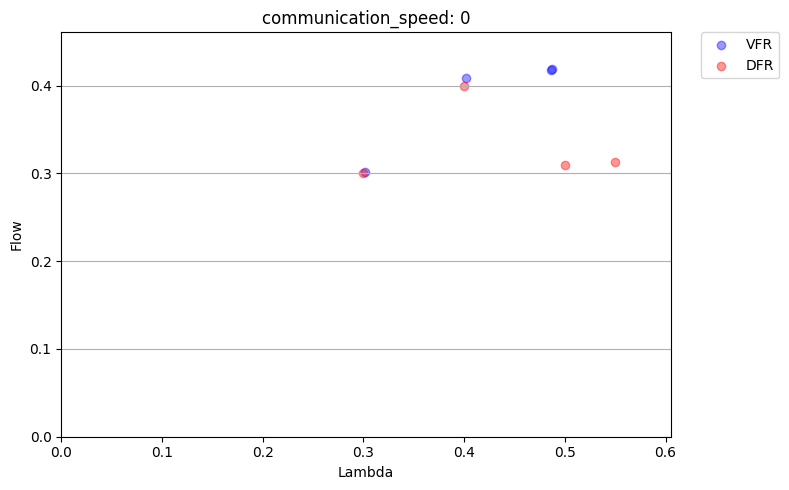

In [8]:
goal_thersh=350

def calc_flow_by_goal_time(goal_time_dict, goal_thresh=200):
    result = []
    for goalObj in goal_time_dict:
        filtered_goal_times = [t for t in goalObj["goal_times"] if t > goal_thresh]
        if len(filtered_goal_times) < 1:
            # print("===該当なし====")
            # print(goalObj)
            # print("=======")
            pass
            
        else:
            result.append({
                'noise_frequency': goalObj['noise_frequency'],
                'communication_speed': goalObj['communication_speed'],
                'TTC': goalObj['TTC'],
                'LAMBDA': goalObj['LAMBDA'],
                'goal_times_over_thresh': len(filtered_goal_times),  # goal_thresh超えの数
                "flow":len(filtered_goal_times) / (filtered_goal_times[-1] -  goal_thresh),
                "flight":goalObj['flight'],
                "effective_lambda": goalObj.get('effective_lambda', goalObj['LAMBDA'])
            })
    return result
    
result = calc_flow_by_goal_time(goal_time_dict, goal_thersh)
print(result)

def plot_flow_vs_density(results, split_plot=False, split_key="communication_speed", savePath=None):
    """
    Lambdaの逆数 (Density) を横軸、Flowを縦軸に、flightごとに色分けしたグラフを作成する関数

    Parameters
    ----------
    results : list of dict
        calc_flow_by_goal_timeの出力結果。
    split_by_communication_speed : bool, optional
        Trueの場合、communication_speedごとにグラフを分割（デフォルトはFalse）


    解釈
    Flow: １秒あたりにゴールする車の数
    Density: 流入レート, 1秒あたりにコースに入ってくる車の数. 
    """

    # flightごとの色を指定
    flight_colors = {
        "vfr": "blue",
        "dfr": "red"
    }

    # communication_speedの値を抽出（重複なし）
    split_key_values = sorted(set(item[split_key] for item in results))

    # グラフの分割方法
    n_cols = len(split_key_values) if split_plot else 1
    n_rows = 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 5))
    print(axes)
    if n_cols == 1:
        axes = [axes]  # サブプロットが1つのときもリストに

    # DensityとFlowの全体的な最大値を取得
    all_density = [1 / item["effective_lambda"] for item in results if item["effective_lambda"] != 0]
    all_flow = [item["flow"] for item in results]

    max_density = max(all_density) * 1.1  # 最大密度の1.05倍
    max_flow = max(all_flow) * 1.1        # 最大流量の1.1倍

    for idx, split_key_value in enumerate(split_key_values):
        ax = axes[idx]

        # 該当のsplit_keyのデータを抽出
        filtered_results = [item for item in results if item[split_key] == split_key_value]

        # flightごとにプロット
        for flight in ["vfr", "dfr"]:
            # flightに対応するデータを抽出
            flight_data = [item for item in filtered_results if item["flight"] == flight]

            # Density（1 / LAMBDA）とFlowを抽出
            density = [1 / item["effective_lambda"] for item in flight_data if item["effective_lambda"] != 0]
            flow = [item["flow"] for item in flight_data]

            # プロット
            ax.scatter(density, flow, label=f"{flight.upper()}", color=flight_colors.get(flight, "gray"), alpha=0.4)

        # 軸ラベル・タイトル
        ax.set_xlabel("Lambda")
        ax.set_ylabel("Flow")
        ax.set_title(f"{split_key}: {split_key_value}")
        ax.legend()
        ax.grid(True, axis="y")
        ax.set_xlim(0, max_density)  # 最大値の1.05倍まで
        ax.set_ylim(0, max_flow)
        ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)


    plt.tight_layout()
    if savePath is not None:
        plt.savefig(savePath, dpi=300)
    
    plt.show()

plot_flow_vs_density(result, split_plot=False)